In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from IPython.display import display
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
def read_csv_files_from_folder(folder_path):
    # Initialize an empty list to store DataFrames
    dfs = []
    # Get a list of files in the folder
    file_list = os.listdir(folder_path)
    # Iterate through the files in the folder
    for file_name in file_list:
        # Check if the file has a .csv extension
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Append the DataFrame to the list
            dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [4]:
cols = ['dataset', 'method', 'protected_metrics_FNR', 'privileged_demotion', 'privileged_promotion', 'protected_demotion', 'protected_promotion']

In [5]:
results = read_csv_files_from_folder('sensibility_results/')

In [6]:
display(results[cols])

,dataset,method,protected_metrics_FNR,privileged_demotion,privileged_promotion,protected_demotion,protected_promotion
0,adult_dataset_reader,ftl_mlp_initializer,0.503049,0.0,0.0,0.0,0.00
1,adult_dataset_reader,ftl_mlp_initializer,0.481707,0.0,0.0,0.0,0.05
2,adult_dataset_reader,ftl_mlp_initializer,0.408537,0.0,0.0,0.0,0.10
3,adult_dataset_reader,ftl_mlp_initializer,0.399390,0.0,0.0,0.0,0.15
4,adult_dataset_reader,ftl_mlp_initializer,0.390244,0.0,0.0,0.0,0.20
...,...,...,...,...,...,...,...
75,bank_dataset_reader,ftl_mlp_initializer,0.013363,0.0,0.0,0.0,0.75
76,bank_dataset_reader,ftl_mlp_initializer,0.151448,0.0,0.0,0.0,0.80
77,bank_dataset_reader,ftl_mlp_initializer,0.162584,0.0,0.0,0.0,0.85
78,bank_dataset_reader,ftl_mlp_initializer,0.131403,0.0,0.0,0.0,0.90


In [7]:
plot_metrics = ['protected_metrics_FNR', 'privileged_metrics_FNR', 'protected_metrics_ACC', 'privileged_metrics_ACC', 'ACC', 'MCC']

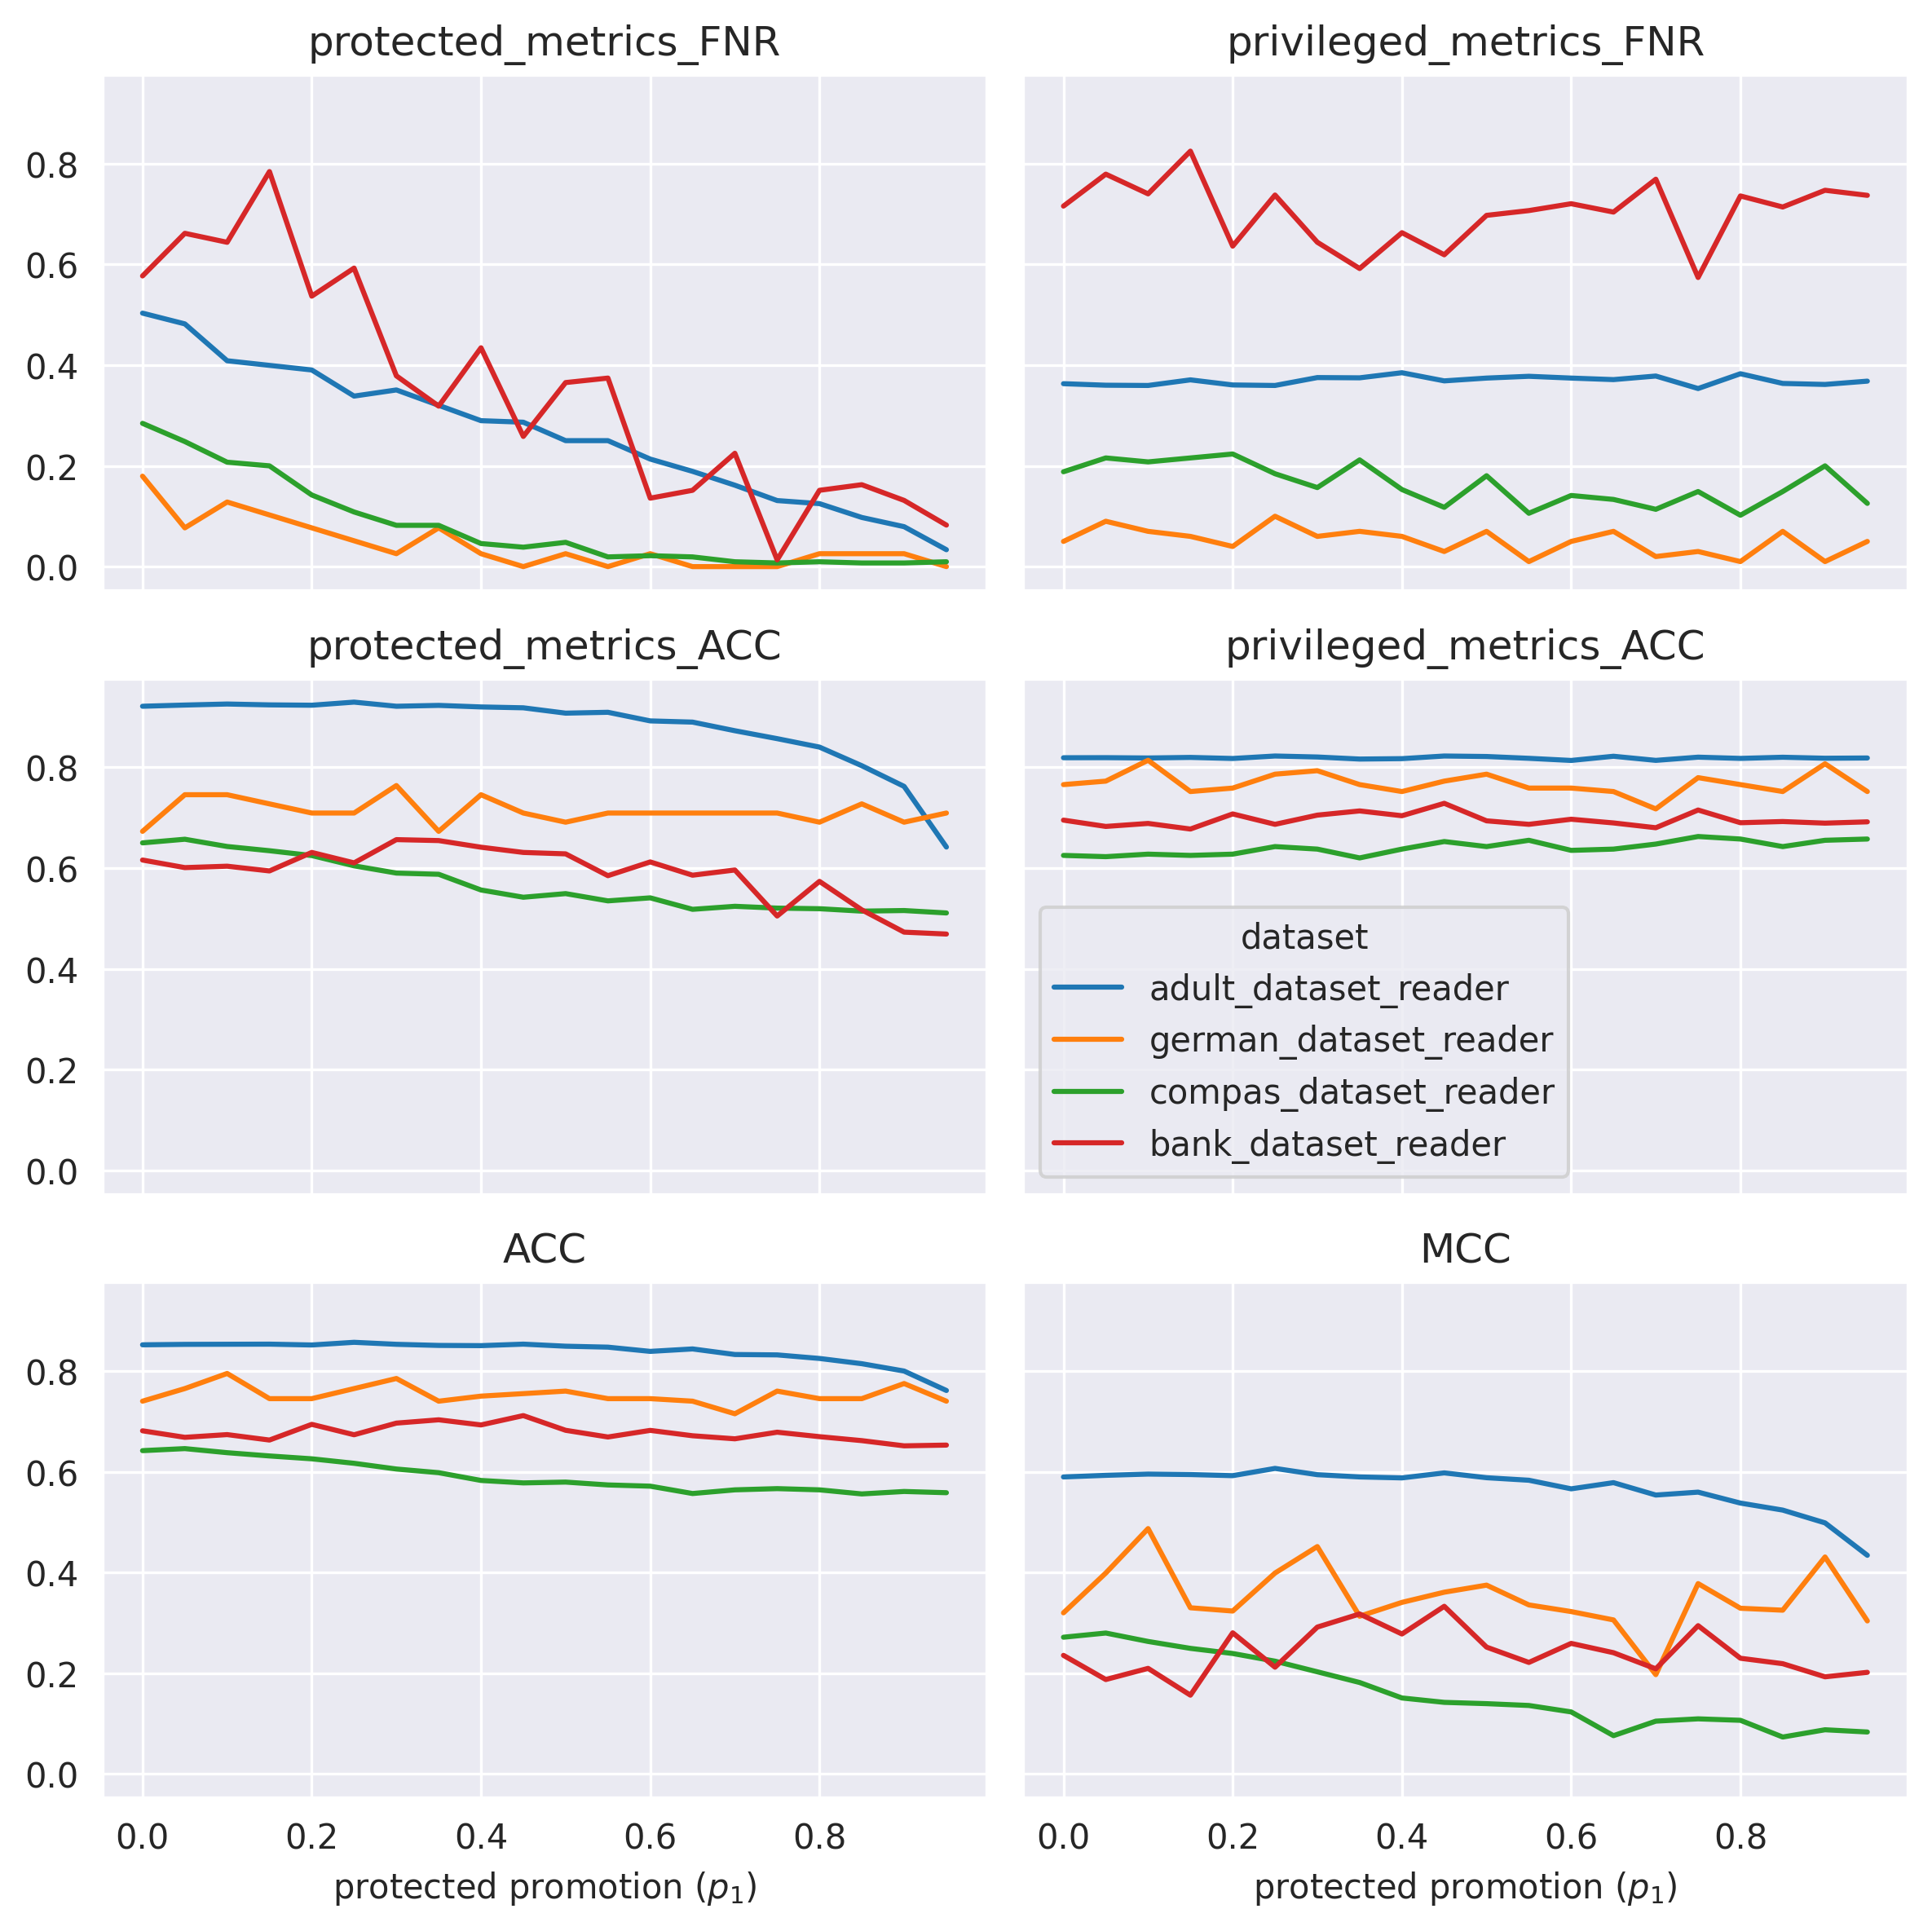

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
for metric, ax in zip(plot_metrics, axes.flatten()):
    if metric == 'privileged_metrics_ACC':
        sns.lineplot(data=results, x='protected_promotion', y=metric, hue='dataset', ax=ax)
    else:
        sns.lineplot(data=results, x='protected_promotion', y=metric, hue='dataset', ax=ax, legend=False)
    ax.set_xlabel('protected promotion ($p_1$)')
    ax.set_title(metric)
    ax.set_ylabel('')
    
plt.tight_layout()
plt.savefig(f'sensibility_plots/sensibility_results.png')


NameError: name 'sns' is not defined